In [ ]:
!nvidia-smi

Mon Apr  5 15:04:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Imports

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.0MB 5.4MB/s 
     |████████████████████████████████| 3.2MB 37.8MB/s 
     |████████████████████████████████| 870kB 37.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=5464dd7657315b8cf46c94636e42f7e69d39440d3dff2a35da6d7094a7ae4d09
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
import pandas as pd
import pickle
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import os
from enum import Enum
from torch.nn import functional as F
import time
import logging
import numpy as np
import math
from matplotlib import pyplot as plt

logger = logging.getLogger(__name__)
random.seed(13)

# Utilities

In [ ]:
def pytorch_cos_sim(a: torch.Tensor, b: torch.Tensor):
    """
    Computes the cosine similarity cos_sim(a[i], b[j]) for all i and j.
    This function can be used as a faster replacement for 1-scipy.spatial.distance.cdist(a,b)
    :return: Matrix with res[i][j]  = cos_sim(a[i], b[j])
    """
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(a)

    if not isinstance(b, torch.Tensor):
        b = torch.tensor(b)

    if len(a.shape) == 1:
        a = a.unsqueeze(0)

    if len(b.shape) == 1:
        b = b.unsqueeze(0)

    a_norm = torch.nn.functional.normalize(a, p=2, dim=1)
    b_norm = torch.nn.functional.normalize(b, p=2, dim=1)
    return torch.mm(a_norm, b_norm.transpose(0, 1))

In [ ]:
def string_sentence(i,qr):
    return qr.loc[i,'Title'] + ' '  + ' '.join(qr.loc[i,'Tags']) + ' '  + qr.loc[i,'Text']

# Model Hyper-Parameters

In [ ]:
folder_quora = '/gdrive/MyDrive/quora_android_2'
folder = '/gdrive/MyDrive/Linked/Models'
os.makedirs(folder,exist_ok = True)
BATCH_SIZE = 128
fin_BATCH_SIZE = 32
n_worker = 2
margin = 0.8

#---------
#Note that amp cannot be used without sigmoid
use_amp = False
use_sig = True
#----------

use_sig_eval = False
# eval_BATCH_SIZE = 4 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Creating Dataset and Dataloader

###Loading Data

In [ ]:
with open(folder_quora+'/data/splits/pandas_split.txt','rb') as a:
    train_qr=pickle.load(a)
    dev_qr = pickle.load(a)
    test_qr = pickle.load(a)

In [ ]:
with open(folder_quora+'/data/splits/train_dev_test.txt','rb') as a:
    train_data=pickle.load(a)
    train_score = pickle.load(a)
    dev_data = pickle.load(a)
    dev_score = pickle.load(a)
    test_data = pickle.load(a)
    test_score = pickle.load(a)

In [ ]:
with open(folder_quora+'/data/splits/data_pos_neg.txt','rb') as a:
    train_data_pos = pickle.load(a)
    train_data_neg = pickle.load(a)
    dev_data_pos = pickle.load(a)
    dev_data_neg = pickle.load(a)
    test_data_pos = pickle.load(a)
    test_data_neg = pickle.load(a)

In [ ]:
qr = pd.concat([train_qr,dev_qr,test_qr])

In [ ]:
print(qr.loc[31,'Text'])

home screen icon email . not want use default email app . use gmail use google gmail app . change icon go remove / disable app ? at&t captivate ( galaxy s ) android 2.1 


### Creating Dataset 

In [ ]:
from transformers import BertTokenizerFast, BertConfig,BertModel
config = BertConfig()
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
class custom_dataset(Dataset):
    def __init__(self,qr,qr_idx,label,transform = None):
        self.qr = qr
        self.qr_idx = qr_idx
        self.label = label
        self.transform = transform
    
    def __getitem__(self,idx):
        id1 = self.qr_idx[idx][0]
        id2 = self.qr_idx[idx][1]

        sample = dict()

        t1 = '[CLS]' + self.qr.loc[id1,'Title'] + ' ' + ' '.join(self.qr.loc[id1,'Tags']) + ' ' + self.qr.loc[id1,'Text'] + '[SEP]'
        t2 = '[CLS]' + self.qr.loc[id2,'Title']+ ' ' + ' '.join(self.qr.loc[id2,'Tags']) + ' ' + self.qr.loc[id2,'Text'] + '[SEP]'
        indexed_t1 = tokenizer.encode(t1,max_length = 512,truncation = True)
        indexed_t2 = tokenizer.encode(t2,max_length = 512,truncation = True)

        while(len(indexed_t1)<512):
            indexed_t1.append(0)
        while(len(indexed_t2)<512):
            indexed_t2.append(0)

        ten_t1 = torch.tensor(indexed_t1)[:512]
        ten_t2 = torch.tensor(indexed_t2)[:512]

        label_cos = self.label[idx]
        if(label_cos==0.0):
            label_cos = -1.0

        try:
            sample["label"] = self.label[idx]
            sample["token"] = [ten_t1,ten_t2] # torch.Size([batch_size, 512])
            sample["label_cos"] = label_cos
        except Exception as e:
            print(e)
        
        return sample

    def __len__(self):
        return len(self.label)

In [ ]:
class pos_dataset(Dataset):
    def __init__(self,qr,qr_idx):
        self.qr = qr
        self.qr_idx = qr_idx
    
    def __getitem__(self,idx):
        id1 = self.qr_idx[idx][0]
        id2 = self.qr_idx[idx][1]

        sample = dict()

        t1 = '[CLS]' + self.qr.loc[id1,'Title'] + ' ' + ' '.join(self.qr.loc[id1,'Tags']) + ' ' + self.qr.loc[id1,'Text'] + '[SEP]'
        t2 = '[CLS]' + self.qr.loc[id2,'Title']+ ' ' + ' '.join(self.qr.loc[id2,'Tags']) + ' ' + self.qr.loc[id2,'Text'] + '[SEP]'
        indexed_t1 = tokenizer.encode(t1,max_length = 512,truncation = True)
        indexed_t2 = tokenizer.encode(t2,max_length = 512,truncation = True)

        while(len(indexed_t1)<512):
            indexed_t1.append(0)
        while(len(indexed_t2)<512):
            indexed_t2.append(0)

        ten_t1 = torch.tensor(indexed_t1)[:512]
        ten_t2 = torch.tensor(indexed_t2)[:512]

        try:
            sample["token"] = [ten_t1,ten_t2] # torch.Size([batch_size, 512])
        except Exception as e:
            print(e)
        
        return sample

    def __len__(self):
        return len(self.qr_idx)

In [ ]:
class ConcatDataset(Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

## Train, dev and test dataloader

In [ ]:
train_dataset = custom_dataset(train_qr,
                               train_data,
                               train_score)

# train_MNR_dataset = pos_dataset(train_qr,
#                                 train_data_pos)

# fin_train_dataset = ConcatDataset(train_dataset,train_MNR_dataset)

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers = n_worker,
    shuffle = True,
    drop_last = True
    )

In [ ]:
dev_dataset = custom_dataset(pd.concat([train_qr,dev_qr]),
                             dev_data,
                             dev_score)

In [ ]:
dev_loader = DataLoader(
    dev_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers = n_worker,
    shuffle = True,
    drop_last = True
    )

In [ ]:
test_dataset = custom_dataset(pd.concat([train_qr,test_qr]),
                              test_data,
                              test_score)

In [ ]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers = n_worker,
    shuffle = True,
    drop_last = True
    )

#Model

## Loading Model 

In [ ]:
from torchvision import models

bert = BertModel.from_pretrained('bert-base-uncased')
bert = bert.to(device)
for param in bert.parameters():
    param.requires_grad = True

## Model Class

In [ ]:
class bertmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = bert
    
    def forward(self,X1):
        #Taking average embeddings of all the words
        bert_out = torch.mean(self.bert(X1).last_hidden_state,dim=1) #[BATCH_SIZE,768] 
        return bert_out

In [ ]:
model = bertmodel().to(device)

# Losses

## Multiple Negative Ranking loss

In [ ]:
class negrankloss():
    def __init__(self,scale: float = 20.0):
        # self.cosine_sim = nn.CosineSimilarity()
        self.scale = scale
        self.cross_entropy = nn.CrossEntropyLoss()

    def cal_loss(self,emb1: torch.Tensor,emb2: torch.Tensor):
        scores  = pytorch_cos_sim(emb1,emb2) *self.scale
        # print(f'The scores of cosine similarity for MNRloss is {scores}')
        labels = torch.tensor(range(len(scores)), dtype=torch.long, device=scores.device)
        loss = self.cross_entropy(scores, labels)
        return loss

In [ ]:
MNRloss = negrankloss()

## Online Constrantive Loss


In [ ]:
class SiameseDistanceMetric(Enum):
    """
    The metric for the contrastive loss
    """
    EUCLIDEAN = lambda x, y: F.pairwise_distance(x, y, p=2)
    MANHATTAN = lambda x, y: F.pairwise_distance(x, y, p=1)
    COSINE_DISTANCE = lambda x, y: 1-F.cosine_similarity(x, y)


In [ ]:
class OnlineConstrantiveLoss():
    def __init__(self,distance_metric=SiameseDistanceMetric.COSINE_DISTANCE,margin: float = 0.8):
        self.distance_metric = distance_metric
        self.margin = margin

    def cal_loss(self,emb1,emb2,labels,size_average=False):
        distance_matrix = self.distance_metric(emb1,emb2)
        # print(f'distance matrix of OCloss is {distance_matrix}')
        negs = distance_matrix[labels == 0]
        poss = distance_matrix[labels == 1]
        # print(f'positive and negatives are {poss} and {negs}')

        # select hard positive and hard negative pairs
        negative_pairs = negs[negs < (poss.max() if len(poss) > 1 else negs.mean())]
        positive_pairs = poss[poss > (negs.min() if len(negs) > 1 else poss.mean())]

        # print(f'positive and negative pairs are {positive_pairs} and {negative_pairs}')

        positive_loss = positive_pairs.pow(2).sum()
        negative_loss = F.relu(self.margin - negative_pairs).pow(2).sum()
        # print(f'positive loss is {positive_loss} and negative loss is {negative_loss}')
        loss = positive_loss + negative_loss
        return loss
    

In [ ]:
OCloss = OnlineConstrantiveLoss(margin = margin)

## Cross Entropy Loss

In [ ]:
class crossentropy():
    def __init__(self):
        self.cross_entropy = nn.BCELoss()
        self.cos_sim =  nn.CosineSimilarity(dim=1,eps=1e-6)
        self.sig = nn.Sigmoid()
        self.BCE_with_sig = nn.BCEWithLogitsLoss()
    
    def cal_loss(self,emb1:torch.Tensor,emb2:torch.Tensor,label:torch.Tensor):
        sim = (self.cos_sim(emb1,emb2))

        if(use_sig == True):
            loss = self.BCE_with_sig(sim,label)
        else:
            sim[sim<0]=0
            loss = self.cross_entropy(sim,label)
        return loss

In [ ]:
BCEloss = crossentropy()

## Cosine Similarity

In [ ]:
class cos_sim():
    def __init__(self):
        self.cossim = nn.CosineEmbeddingLoss()

    def cal_loss(self,emb1,emb2,target):
        loss = self.cossim(emb1,emb2,target)
        return loss

In [ ]:
Cosloss = cos_sim()

# Evaluators: AUC(0.05) and Binary accuracy

In [ ]:
import sklearn.metrics as skm

In [ ]:
class AUC():
    def __init__(self,max_fpr:float = 0.05):
        self.max_fpr = 0.05
        self.cos_sim =  nn.CosineSimilarity(dim=1,eps=1e-6)
        self.sig = nn.Sigmoid()

    def cal(self,model:bertmodel,loader:DataLoader):
        y_pred = []
        y_true = []
        y_pred_sig = []
        start = time.time()
        for i,batch in enumerate(loader):
            with torch.no_grad():
                label = batch["label"]
                label = label.float()
                token = batch["token"]

                token[0],token[1] = token[0].to(device), token[1].to(device)
                label = label.to(device)
            
                # compute the model output
                yhat1 = model(token[0])
                yhat2 = model(token[1])

                if(i%1000==0):
                    print(f'    {i} iterations have been done in {time.time()-start} seconds')

                sim = (self.cos_sim(yhat1,yhat2))
                a=self.sig(sim)
                a[a>0.5] = 1
                a[a<0.5] = 0

                y_pred_sig.append(a.cpu().numpy())
                y_pred.append(sim.cpu().numpy())
                y_true.append(label.cpu().numpy())

                del  label, token,yhat1,yhat2,sim,a 
        
        y_true = np.array(y_true).flatten()
        y_pred = np.array(y_pred).flatten()
        y_pred_sig = np.array(y_pred_sig).flatten()
        y_auc = np.array(y_auc).flatten()
        Bin_score = skm.accuracy_score(y_true,y_pred_sig) 
        AUC_score = skm.roc_auc_score(y_true,y_pred,max_fpr = self.max_fpr)
        conf_matrix = skm.confusion_matrix(y_true,y_pred_sig)
        plt.hist(y_pred,bins='auto')
        plt.show()
        return AUC_score,Bin_score,conf_matrix


In [ ]:
AUC_evaluator = AUC()

# Calculating loss and executing

In [ ]:
save_dir = folder + '/model_state_dict'
os.makedirs(save_dir,exist_ok = True)

In [ ]:
from torch.optim import Adam
from torch.nn import BCELoss
import time
import copy
from transformers import get_linear_schedule_with_warmup

def train_model(train_loader, model,num_epochs):
    model.train()

    since = time.time()

    optimizer = Adam(model.parameters(), lr=1e-4)
    train_steps = num_epochs
    
    best_acc = 0.0

    acc_steps = fin_BATCH_SIZE/BATCH_SIZE

    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    # torch.autograd.set_detect_anomaly(True)

    # Evaluating on dev loader
    print('Running dev_evaluator for 2000 samples i.e. 1000 iterations. Time taken: 5 min')
    a,b,c = AUC_evaluator.cal(model,dev_loader)
    print(f'AUC score is {a}  while binary score is {b} and the confusion matrix is {c} on dev loader before training')

    for epoch in range(num_epochs):
        # enumerate mini batches
        # avg_loss = 0
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        running_OCloss = 0.0
        running_MNRloss = 0.0
        running_BCEloss = 0.0
        running_Cosloss = 0.0

        model.zero_grad()

        for i, batch in enumerate(train_loader):

            with torch.cuda.amp.autocast(enabled=use_amp):
                
                if(i%4000 == 0 and i!=0 ):
                    print('Running dev_evaluator for 2000 samples i.e. 1000 iterations. Time taken: 5 min')
                    a,b,c = AUC_evaluator.cal(model,dev_loader)
                    print(f'AUC score is {a}  while binary score is {b} and the confusion matrix is {c} on dev loader after {i} iterations and {epoch+1} epoch')
                    torch.save(model.state_dict(), save_dir+'/bert_cos.bin')
                    print(f'Model is saved after {i} iterations ')
        
                label = batch["label"]
                label = label.float()
                token = batch["token"]
                label_cos = batch['label_cos']

                # pos_token = batch[1]['token']

                token[0],token[1] = token[0].to(device), token[1].to(device)
                # pos_token[0],pos_token[1] = pos_token[0].to(device), pos_token[1].to(device)
                label = label.to(device)
                label_cos = label_cos.to(device)
                
                # compute the model output
                yhat1= model(token[0])
                yhat2 = model(token[1])

                # yhat1_pos = model(pos_token[0])
                # yhat2_pos = model(pos_token[1])
                
                BCEloss_val = BCEloss.cal_loss(yhat1,yhat2,label)
                running_BCEloss += BCEloss_val.item()*BATCH_SIZE
                BCEloss_val = BCEloss_val/acc_steps

                # MNRloss_val = MNRloss.cal_loss(yhat1_pos,yhat2_pos)
                # running_MNRloss += MNRloss_val.item()*BATCH_SIZE
                # MNRloss_val = MNRloss_val/acc_steps

                OCloss_val = OCloss.cal_loss(yhat1,yhat2,label)
                running_OCloss +=  OCloss_val.item()*BATCH_SIZE
                OCloss_val = OCloss_val/acc_steps

                Cosloss_val = Cosloss.cal_loss(yhat1,yhat2,label_cos)
                running_Cosloss += Cosloss_val.item()*BATCH_SIZE
                Cosloss_val = Cosloss_val/acc_steps
            
            scaler.scale(Cosloss_val).backward(retain_graph = True)
            scaler.scale(BCEloss_val).backward(retain_graph = True)
            # scaler.scale(MNRloss_val).backward(retain_graph=True)
            scaler.scale(OCloss_val).backward()

            if((i+1)%acc_steps==0):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            if(i%500 == 0 ):
                print('OCloss is {} and BCEloss is {} and MNRloss is {} and Cosloss is {}  and time taken is {} after {} iterations'.format(
                    running_OCloss/((i+1)*BATCH_SIZE),
                    running_BCEloss/((i+1)*BATCH_SIZE),
                    running_MNRloss/(i+1)*BATCH_SIZE,
                    running_Cosloss/(i+1)*BATCH_SIZE,
                    time.time()-since,
                    i))
            
            del OCloss_val,BCEloss_val, yhat1,yhat2, label, token,Cosloss_val,label_cos

        epoch_OC = running_OCloss / len(train_data)
        epoch_BCE = running_BCEloss / len(train_data)
        epoch_MNR = running_MNRloss / len(train_data)
        epoch_Cos = running_Cosloss/len(train_data)
        print(f'{epoch+1} Epoch completed. OCloss is {epoch_OC} and BCEloss is {epoch_BCE} and MNRloss is {epoch_MNR} and Cosloss is {epoch_Cos}')
        a,b,c = AUC_evaluator.cal(model,train_loader)
        print(f'AUC and Bin_acc after training {epoch+1} on train dataloader is {a,b} and confusion matrix is {c}')
        a,b,c = AUC_evaluator.cal(model,dev_loader)
        print(f'AUC and Bin_acc after training {epoch+1} on dev dataloader is {a,b} and the confusion matris is {c}')
        torch.save(model.state_dict(), save_dir+'/bert_cos.bin')
        print(f'Model is saved after {epoch+1} epochs ')
        
        

In [ ]:
# model.load_state_dict(torch.load(folder+'/model.bin'))

In [ ]:
# os.makedirs('./model',exist_ok=True)
# torch.save(model.state_dict(), '/gdrive/MyDrive/MultiModal/model.bin')

# Training the model

In [ ]:
model.load_state_dict(torch.load(save_dir+'/bert_cos.bin'))

<All keys matched successfully>

In [ ]:
AUC_evaluator.cal(model,train_loader)

    0 iterations have been done in 0.5002717971801758 seconds


UnboundLocalError: ignored

In [ ]:
AUC_evaluator.cal(model,dev_loader)

109482240
Running dev_evaluator for 2000 samples i.e. 1000 iterations. Time taken: 5 min
    0 iterations have been done in 0.31961774826049805 seconds


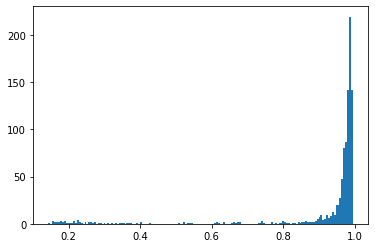

AUC score is 0.5037090250070632  while binary score is 0.5 and the confusion matrix is [[  0 488]
 [  0 488]] on dev loader before training
Epoch 0/4
----------
OCloss is 1.2373502254486084 and BCEloss is 1.3003754615783691 and MNRloss is 0.0 and Cosloss is 15.717244148254395  and time taken is 74.41431951522827 after 0 iterations
OCloss is 0.474021737388021 and BCEloss is 0.7216411588077773 and MNRloss is 0.0 and Cosloss is 6.934771479246859  and time taken is 1370.6295444965363 after 500 iterations
OCloss is 0.3771525548000426 and BCEloss is 0.6822808179762456 and MNRloss is 0.0 and Cosloss is 5.993706772734711  and time taken is 2658.891426086426 after 1000 iterations
OCloss is 0.3471635688902924 and BCEloss is 0.6697300540098423 and MNRloss is 0.0 and Cosloss is 5.601141032801915  and time taken is 3945.9590888023376 after 1500 iterations
OCloss is 0.3216458582849692 and BCEloss is 0.6551029457562212 and MNRloss is 0.0 and Cosloss is 5.250447229247192  and time taken is 5230.572098

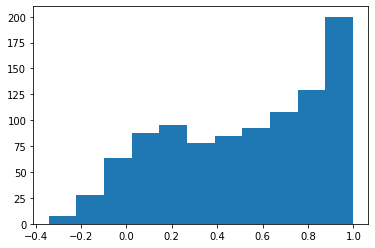

AUC score is 0.744476946505971  while binary score is 0.5819672131147541 and the confusion matrix is [[ 80 408]
 [  0 488]] on dev loader after 4000 iterations and 1 epoch
Model is saved after 4000 iterations 
OCloss is 0.2791523764712039 and BCEloss is 0.6274350649623447 and MNRloss is 0.0 and Cosloss is 4.5336787026264735  and time taken is 10434.50796365738 after 4000 iterations
OCloss is 0.2723358069557262 and BCEloss is 0.6225236832459909 and MNRloss is 0.0 and Cosloss is 4.431445810034245  and time taken is 11719.019290685654 after 4500 iterations
OCloss is 0.2652614910366243 and BCEloss is 0.6184436633595941 and MNRloss is 0.0 and Cosloss is 4.32826463081996  and time taken is 12998.897641658783 after 5000 iterations
OCloss is 0.2565339907552332 and BCEloss is 0.6135568903849529 and MNRloss is 0.0 and Cosloss is 4.22062945460985  and time taken is 14277.86932849884 after 5500 iterations


In [ ]:
#Overall parameters in model
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
train_model(train_loader,model,5)

# Evaluator

## Binary Classification Evaluator

In [ ]:
# from . import SentenceEvaluator
import logging
import os
import csv
from sklearn.metrics.pairwise import paired_cosine_distances, paired_euclidean_distances, paired_manhattan_distances
from sklearn.metrics import average_precision_score
import numpy as np
from typing import List
# from ..readers import InputExample


logger = logging.getLogger(__name__)


In [ ]:
class BinaryClassificationEvaluator():
    """
    Evaluate a model based on the similarity of the embeddings by calculating the accuracy of identifying similar and
    dissimilar sentences.
    The metrics are the cosine similarity as well as euclidean and Manhattan distance
    The returned score is the accuracy with a specified metric.
    The results are written in a CSV. If a CSV already exists, then values are appended.
    The labels need to be 0 for dissimilar pairs and 1 for similar pairs.
    :param sentences1: The first column of sentences
    :param sentences2: The second column of sentences
    :param labels: labels[i] is the label for the pair (sentences1[i], sentences2[i]). Must be 0 or 1
    :param name: Name for the output
    :param batch_size: Batch size used to compute embeddings
    :param show_progress_bar: If true, prints a progress bar
    :param write_csv: Write results to a CSV file
    """

    def __init__(self,
                 dataset,
                 name: str = '',
                 batch_size: int = 32,
                 show_progress_bar: bool = False,
                 write_csv: bool = True
                 ):
        
        self.dataset = dataset
        self.labels = list()
        self.write_csv = write_csv
        self.name = name
        self.batch_size = batch_size
        self.dataloader = DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            pin_memory=True,
            num_workers = 8,
            shuffle = True
        )

        if show_progress_bar is None:
            show_progress_bar = (logger.getEffectiveLevel() == logging.INFO or logger.getEffectiveLevel() == logging.DEBUG)
        self.show_progress_bar = show_progress_bar

        self.csv_file = "binary_classification_evaluation" + ("_"+name if name else '') + "_results.csv"
        self.csv_headers = ["epoch", "steps",
                            "cosine_acc", "cosine_acc_threshold", "cosine_f1", "cosine_precision", "cosine_recall", "cosine_f1_threshold", "cosine_average_precision",
                            "manhatten_acc", "manhatten_acc_threshold", "manhatten_f1", "manhatten_precision", "manhatten_recall", "manhatten_f1_threshold", "manhatten_average_precision",
                            "eucledian_acc", "eucledian_acc_threshold", "eucledian_f1", "eucledian_precision", "eucledian_recall", "eucledian_f1_threshold", "eucledian_average_precision"]


    # @classmethod
    # def from_input_examples(cls, examples: List[InputExample], **kwargs):
    #     sentences1 = []
    #     sentences2 = []
    #     scores = []

    #     for example in examples:
    #         sentences1.append(example.texts[0])
    #         sentences2.append(example.texts[1])
    #         scores.append(example.label)
    #     return cls(sentences1, sentences2, scores, **kwargs)

    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:

        if epoch != -1:
            if steps == -1:
                out_txt = f" after epoch {epoch}:"
            else:
                out_txt = f" in epoch {epoch} after {steps} steps:"
        else:
            out_txt = ":"

        logger.info("Binary Accuracy Evaluation of the model on " + self.name + " dataset" + out_txt)
        
        embeddings1 = list()
        embeddings2 = list()

        with torch.no_grad():
            model.eval()
            for i, batch in enumerate(self.dataloader):
                images = batch["image"]
                label = batch["label"]
                label = label.float()
                token = batch["token"]
                
                # print(images,label,token)

                images[0],images[1] = images[0].to(device),images[1].to(device)
                token[0],token[1] = token[0].to(device), token[1].to(device)
                label = label.to(device)
                
                # compute the model output
                yhat1 = model(images[0], token[0])
                yhat2 = model(images[1],token[1])

                for j in yhat1:
                    embeddings1.append(j.cpu().detach().numpy())
                for j in yhat2:
                    embeddings2.append(j.cpu().detach().numpy())
                for j in label:
                    self.labels.append(float(j))
                
                if(i%30==0 and i!=0):
                    print(f'Completed {i} iterations')

        cosine_scores = 1-paired_cosine_distances(embeddings1, embeddings2)
        manhattan_distances = paired_manhattan_distances(embeddings1, embeddings2)
        euclidean_distances = paired_euclidean_distances(embeddings1, embeddings2)


        labels = np.asarray(self.labels)

        file_output_data = [epoch, steps]

        main_score = None
        for name, scores, reverse in [['Cosine-Similarity', cosine_scores, True], ['Manhatten-Distance', manhattan_distances, False], ['Euclidean-Distance', euclidean_distances, False]]:
            acc, acc_threshold = self.find_best_acc_and_threshold(scores, labels, reverse)
            f1, precision, recall, f1_threshold = self.find_best_f1_and_threshold(scores, labels, reverse)
            ap = average_precision_score(labels, scores * (1 if reverse else -1))

            logger.info("Accuracy with {}:           {:.2f}\t(Threshold: {:.4f})".format(name, acc * 100, acc_threshold))
            logger.info("F1 with {}:                 {:.2f}\t(Threshold: {:.4f})".format(name, f1 * 100, f1_threshold))
            logger.info("Precision with {}:          {:.2f}".format(name, precision * 100))
            logger.info("Recall with {}:             {:.2f}".format(name, recall * 100))
            logger.info("Average Precision with {}:  {:.2f}\n".format(name, ap * 100))

            file_output_data.extend([acc, acc_threshold, f1, precision, recall, f1_threshold, ap])

            if main_score is None: #Use AveragePrecision with Cosine-Similarity as main score
                main_score = ap

        if output_path is not None and self.write_csv:
            csv_path = os.path.join(output_path, self.csv_file)
            if not os.path.isfile(csv_path):
                with open(csv_path, mode="w", encoding="utf-8") as f:
                    writer = csv.writer(f)
                    writer.writerow(self.csv_headers)
                    writer.writerow(file_output_data)
            else:
                with open(csv_path, mode="a", encoding="utf-8") as f:
                    writer = csv.writer(f)
                    writer.writerow(file_output_data)

        return main_score

    @staticmethod
    def find_best_acc_and_threshold(scores, labels, high_score_more_similar: bool):
        # assert len(scores) == len(labels)
        rows = list(zip(scores, labels))

        rows = sorted(rows, key=lambda x: x[0], reverse=high_score_more_similar)

        max_acc = 0
        best_threshold = -1

        positive_so_far = 0
        remaining_negatives = sum(labels == 0)

        for i in range(len(rows)-1):
            score, label = rows[i]
            if label == 1:
                positive_so_far += 1
            else:
                remaining_negatives -= 1

            acc = (positive_so_far + remaining_negatives) / len(labels)
            if acc > max_acc:
                max_acc = acc
                best_threshold = (rows[i][0] + rows[i+1][0]) / 2

        return max_acc, best_threshold

    @staticmethod
    def find_best_f1_and_threshold(scores, labels, high_score_more_similar: bool):
        # assert len(scores) == len(labels)

        scores = np.asarray(scores)
        labels = np.asarray(labels)

        rows = list(zip(scores, labels))

        rows = sorted(rows, key=lambda x: x[0], reverse=high_score_more_similar)

        best_f1 = best_precision = best_recall = 0
        threshold = 0
        nextract = 0
        ncorrect = 0
        total_num_duplicates = sum(labels)

        for i in range(len(rows)-1):
            score, label = rows[i]
            nextract += 1

            if label == 1:
                ncorrect += 1

            if ncorrect > 0:
                precision = ncorrect / nextract
                recall = ncorrect / total_num_duplicates
                f1 = 2 * precision * recall / (precision + recall)
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

        return best_f1, best_precision, best_recall, threshold

In [ ]:
dev_BCEvaluator = BinaryClassificationEvaluator(dev_dataset,batch_size=BATCH_SIZE,show_progress_bar=True)
os.makedirs(folder+'/dev',exist_ok = True)
dev_BCEvaluator(model,output_path=folder+'/dev')

NameError: ignored

In [ ]:
train_BCEvaluator = BinaryClassificationEvaluator(train_dataset,batch_size=BATCH_SIZE,show_progress_bar=True)
os.makedirs(folder+'/train',exist_ok = True)
train_BCEvaluator(model,output_path=folder+'/train')

## Information retreival evaluator

In [ ]:
import torch
import logging
from tqdm import tqdm, trange
import os
import numpy as np
from typing import List, Tuple, Dict, Set

In [ ]:
class infodataset(Dataset):
    def __init__(self,qr,qr_idx,img_dir,transform = None):
        self.qr = qr
        self.qr_idx = qr_idx
        self.img_dir = img_dir
        self.transform = transform

    def image_adder(self,id1):
        img_id1 = list()
        if((self.qr.at[id1,'Attachments'])!=None):
            for i in self.qr.at[id1,'Attachments']:
                try:
                    img_path = os.path.join(self.img_dir,i)
                    img = Image.open(img_path).convert('RGB')
                    if(self.transform):
                        img = self.transform(img)
                        img.reshape(3,224,224)
                    img_id1.append(img)
                except Exception as e: 
                    print(e)
        else:
            img_id1.append(torch.zeros(3,224,224))

        # Work on this, for few examples, it is still saying list index out of range
        if(len(img_id1)==0):
            # print('No attachments found for id {}'.format(id1))
            print(f'Something went wrong with the image of id {id1}')
            img_id1.append(torch.zeros(3,224,224))

        return img_id1
    
    def __getitem__(self,idx):
        id1 = self.qr_idx[idx]
        img_id1 = self.image_adder(id1)

        # print(len(img_id1))

        # print('Printing id1 {} and len {} and id2 {} and len {} '.format(
        #     id1,len(img_id1),
        #     id2, len(img_id2)
        # ))

        # print('Printing id1 shape {} and id2  shape {}'.format(
        #     img_id1[0].shape,
        #     img_id2[0].shape
        # ))        

        sample = {
            'image': img_id1[0]    #Currently taking only one input image
        }

        t1 = '[CLS]' + self.qr.loc[id1,'Title'] + ' ' + ' '.join(self.qr.loc[id1,'Tags']) + ' ' + self.qr.loc[id1,'Text'] + '[SEP]'
        tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
        t1_token = tokenizer.tokenize(t1)
        indexed_t1 = tokenizer.convert_tokens_to_ids(t1_token)
        
        while(len(indexed_t1)<512):
            indexed_t1.append(0)
        
        ten_t1 = torch.tensor(indexed_t1)[:512]
        
        try:
            sample["token"] = ten_t1 # torch.Size([batch_size, 512])
        except Exception as e:
            print(e)
        
        return sample

    def __len__(self):
        return len(self.qr_idx)

In [ ]:
class InformationRetreivalEvaluator():
    def __init__(self,
                 qr,
                 queries: Dict[str, str],  #qid => query
                 corpus: Dict[str, str],  #cid => doc
                 relevant_docs: Dict[str, Set[str]],  #qid => Set[cid]
                 corpus_chunk_size: int = 50000,
                 mrr_at_k: List[int] = [10],
                 ndcg_at_k: List[int] = [10],
                 accuracy_at_k: List[int] = [1, 3, 5, 10],
                 precision_recall_at_k: List[int] = [1, 3, 5, 10],
                 map_at_k: List[int] = [100],
                 show_progress_bar: bool = False,
                 batch_size: int = 32,
                 name: str = '',
                 write_csv: bool = True
                 ):
        
        self.qr = qr
        self.queries_ids = []
        for qid in queries:
            if qid in relevant_docs and len(relevant_docs[qid]) > 0:
                self.queries_ids.append(qid)

        self.queries = [queries[qid] for qid in self.queries_ids]

        self.corpus_ids = list(corpus.keys())
        self.corpus = [corpus[cid] for cid in self.corpus_ids]

        self.relevant_docs = relevant_docs
        self.corpus_chunk_size = corpus_chunk_size
        self.mrr_at_k = mrr_at_k
        self.ndcg_at_k = ndcg_at_k
        self.accuracy_at_k = accuracy_at_k
        self.precision_recall_at_k = precision_recall_at_k
        self.map_at_k = map_at_k

        self.show_progress_bar = show_progress_bar
        self.batch_size = batch_size
        self.name = name
        self.write_csv = write_csv

        if name:
            name = "_" + name

        self.csv_file: str = "Information-Retrieval_evaluation" + name + "_results.csv"
        self.csv_headers = ["epoch", "steps"]


        for k in accuracy_at_k:
            self.csv_headers.append("Accuracy@{}".format(k))

        for k in precision_recall_at_k:
            self.csv_headers.append("Precision@{}".format(k))
            self.csv_headers.append("Recall@{}".format(k))

        for k in mrr_at_k:
            self.csv_headers.append("MRR@{}".format(k))

        for k in ndcg_at_k:
            self.csv_headers.append("NDCG@{}".format(k))

        for k in map_at_k:
            self.csv_headers.append("MAP@{}".format(k))
    
    def __call__(self,model : BridgeModel,output_path: str = None,epoch: int = -1, steps: int = -1) ->float:
        if epoch != -1:
            out_txt = " after epoch {}:".format(epoch) if steps == -1 else " in epoch {} after {} steps:".format(epoch, steps)
        else:
            out_txt = ":"

        logger.info("Information Retrieval Evaluation on " + self.name + " dataset" + out_txt)

        max_k = max(max(self.mrr_at_k), max(self.ndcg_at_k), max(self.accuracy_at_k), max(self.precision_recall_at_k), max(self.map_at_k))

        query_embeddings = self.get_embeddings(model,self.qr,self.queries_ids)

        queries_result_list = [[] for _ in range(len(query_embeddings))]

        itr = range(0, len(self.corpus), self.corpus_chunk_size)

        if self.show_progress_bar:
            itr = tqdm(itr, desc='Corpus Chunks')

        #Iterate over chunks of the corpus
        for corpus_start_idx in itr:
            corpus_end_idx = min(corpus_start_idx + self.corpus_chunk_size, len(self.corpus))

            #Encode chunk of corpus
            sub_corpus_embeddings = self.get_embeddings(model,self.qr,self.corpus_ids[corpus_start_idx:corpus_end_idx])

            #Compute cosine similarites
            cos_scores = pytorch_cos_sim(query_embeddings, sub_corpus_embeddings)
            del sub_corpus_embeddings

            #Get top-k values
            cos_scores_top_k_values, cos_scores_top_k_idx = torch.topk(cos_scores, min(max_k, len(cos_scores[0])), dim=1, largest=True, sorted=False)
            cos_scores_top_k_values = cos_scores_top_k_values.cpu().tolist()
            cos_scores_top_k_idx = cos_scores_top_k_idx.cpu().tolist()
            del cos_scores

            for query_itr in range(len(query_embeddings)):
                for sub_corpus_id, score in zip(cos_scores_top_k_idx[query_itr], cos_scores_top_k_values[query_itr]):
                    corpus_id = self.corpus_ids[corpus_start_idx+sub_corpus_id]
                    queries_result_list[query_itr].append({'corpus_id': corpus_id, 'score': score})


        #Compute scores
        scores = self.compute_metrics(queries_result_list)

        #Output
        self.output_scores(scores)


        # logger.info("Queries: {}".format(len(self.queries)))
        # logger.info("Corpus: {}\n".format(len(self.corpus)))

        if output_path is not None and self.write_csv:
            csv_path = os.path.join(output_path, self.csv_file)
            if not os.path.isfile(csv_path):
                fOut = open(csv_path, mode="w", encoding="utf-8")
                fOut.write(",".join(self.csv_headers))
                fOut.write("\n")

            else:
                fOut = open(csv_path, mode="a", encoding="utf-8")

            output_data = [epoch, steps]
            for k in self.accuracy_at_k:
                output_data.append(scores['accuracy@k'][k])

            for k in self.precision_recall_at_k:
                output_data.append(scores['precision@k'][k])
                output_data.append(scores['recall@k'][k])

            for k in self.mrr_at_k:
                output_data.append(scores['mrr@k'][k])

            for k in self.ndcg_at_k:
                output_data.append(scores['ndcg@k'][k])

            for k in self.map_at_k:
                output_data.append(scores['map@k'][k])

            fOut.write(",".join(map(str,output_data)))
            fOut.write("\n")
            fOut.close()

        return scores['map@k'][max(self.map_at_k)]


    def compute_metrics(self, queries_result_list: List[object]):
        # Init score computation values
        num_hits_at_k = {k: 0 for k in self.accuracy_at_k}
        precisions_at_k = {k: [] for k in self.precision_recall_at_k}
        recall_at_k = {k: [] for k in self.precision_recall_at_k}
        MRR = {k: 0 for k in self.mrr_at_k}
        ndcg = {k: [] for k in self.ndcg_at_k}
        AveP_at_k = {k: [] for k in self.map_at_k}

        # Compute scores on results
        for query_itr in range(len(queries_result_list)):
            query_id = self.queries_ids[query_itr]

            # Sort scores
            top_hits = sorted(queries_result_list[query_itr], key=lambda x: x['score'], reverse=True)
            query_relevant_docs = self.relevant_docs[query_id]

            # Accuracy@k - We count the result correct, if at least one relevant doc is accross the top-k documents
            for k_val in self.accuracy_at_k:
                for hit in top_hits[0:k_val]:
                    if hit['corpus_id'] in query_relevant_docs:
                        num_hits_at_k[k_val] += 1
                        break

            # Precision and Recall@k
            for k_val in self.precision_recall_at_k:
                num_correct = 0
                for hit in top_hits[0:k_val]:
                    if hit['corpus_id'] in query_relevant_docs:
                        num_correct += 1

                precisions_at_k[k_val].append(num_correct / k_val)
                recall_at_k[k_val].append(num_correct / len(query_relevant_docs))

            # MRR@k
            for k_val in self.mrr_at_k:
                for rank, hit in enumerate(top_hits[0:k_val]):
                    if hit['corpus_id'] in query_relevant_docs:
                        MRR[k_val] += 1.0 / (rank + 1)
                        break

            # NDCG@k
            for k_val in self.ndcg_at_k:
                predicted_relevance = [1 if top_hit['corpus_id'] in query_relevant_docs else 0 for top_hit in top_hits[0:k_val]]
                true_relevances = [1] * len(query_relevant_docs)

                ndcg_value = self.compute_dcg_at_k(predicted_relevance, k_val) / self.compute_dcg_at_k(true_relevances, k_val)
                ndcg[k_val].append(ndcg_value)

            # MAP@k
            for k_val in self.map_at_k:
                num_correct = 0
                sum_precisions = 0

                for rank, hit in enumerate(top_hits[0:k_val]):
                    if hit['corpus_id'] in query_relevant_docs:
                        num_correct += 1
                        sum_precisions += num_correct / (rank + 1)

                avg_precision = sum_precisions / min(k_val, len(query_relevant_docs))
                AveP_at_k[k_val].append(avg_precision)

        # Compute averages
        for k in num_hits_at_k:
            num_hits_at_k[k] /= len(self.queries_ids)

        for k in precisions_at_k:
            precisions_at_k[k] = np.mean(precisions_at_k[k])

        for k in recall_at_k:
            recall_at_k[k] = np.mean(recall_at_k[k])

        for k in ndcg:
            ndcg[k] = np.mean(ndcg[k])

        for k in MRR:
            MRR[k] /= len(self.queries_ids)

        for k in AveP_at_k:
            AveP_at_k[k] = np.mean(AveP_at_k[k])


        return {'accuracy@k': num_hits_at_k, 'precision@k': precisions_at_k, 'recall@k': recall_at_k, 'ndcg@k': ndcg, 'mrr@k': MRR, 'map@k': AveP_at_k}


    def output_scores(self, scores):
        for k in scores['accuracy@k']:
            logger.info("Accuracy@{}: {:.2f}%".format(k, scores['accuracy@k'][k]*100))

        for k in scores['precision@k']:
            logger.info("Precision@{}: {:.2f}%".format(k, scores['precision@k'][k]*100))

        for k in scores['recall@k']:
            logger.info("Recall@{}: {:.2f}%".format(k, scores['recall@k'][k]*100))

        for k in scores['mrr@k']:
            logger.info("MRR@{}: {:.4f}".format(k, scores['mrr@k'][k]))

        for k in scores['ndcg@k']:
            logger.info("NDCG@{}: {:.4f}".format(k, scores['ndcg@k'][k]))

        for k in scores['map@k']:
            logger.info("MAP@{}: {:.4f}".format(k, scores['map@k'][k]))


    @staticmethod
    def compute_dcg_at_k(relevances, k):
        dcg = 0
        for i in range(min(len(relevances), k)):
            dcg += relevances[i] / np.log2(i + 2)  #+2 as we start our idx at 0
        return dcg
    
    def get_embeddings(self,model,qr,qr_idx):
        info_dataset = infodataset(qr,qr_idx,img_dir,transform = transform_pipe)
        info_loader = DataLoader(
            info_dataset,
            batch_size=BATCH_SIZE,
            pin_memory=True,
            num_workers = 8,
            )
        
        embeddings = list()
        since = time.time()
        for i,batch in enumerate(info_loader):
            model.eval()

            text = batch['token']
            images = batch['image']

            text,images = torch.tensor(text).to(device), torch.tensor(images).to(device)

            with torch.no_grad():
                yhat = model.forward(images,text)
            
            for j in yhat:
                embeddings.append(j.cpu().detach().numpy())
            
            if(i%40==0):
                print(f'{i} iterations hase been completed, and model is running for {time.time()-since}')
        
        return embeddings


In [ ]:
with open(folder_quora+'/devinfo_100.txt','rb') as a:
    queries_dev = pickle.load(a)
    rel_docs_dev= pickle.load(a)

with open(folder_quora+'/testinfo_100.txt','rb') as a:
    queries_test= pickle.load(a)
    rel_docs_test= pickle.load(a)

with open(folder_quora+'/traininfo_100.txt','rb') as a:
    queries_train= pickle.load(a)
    rel_docs_train= pickle.load(a)

In [ ]:
def corpus(qr):
    corpus = dict()
    for i in qr.index.values:
        corpus[i] = 'I dont care'
    return corpus

In [ ]:
train_inforet = InformationRetreivalEvaluator(train_qr,queries_train,corpus(train_qr),rel_docs_train)
os.makedirs(folder+'/train',exist_ok=True)
train_inforet(model,folder+'/train')

In [ ]:
dev_inforet = InformationRetreivalEvaluator(pd.concat([train_qr,dev_qr]),queries_dev,corpus(train_qr),rel_docs_dev)
os.makedirs(folder+'/dev',exist_ok=True)
dev_inforet(model,folder+'/dev')